# Example 2: Exon junction metagenes

In this example, we will reproduce the base-pair resolution metagenes around exon junctions, as seen in Hauer et al, 2015. In Hauer et al, they show that using the centre of reads works better than using the base just 5' to the end of the read. We will reproduce the evidence for this claim.

In [15]:
from iCLIP import TranscriptCoordInterconverter, count_transcript
from iCLIP.meta import get_window
import pandas as pd
from iCLIP import make_getter
from iCLIP.meta import sum_row_norm
from CGAT import IOTools, GTF

In [64]:
def get_junction_profiles(iclip_data, gtf_file):

  counts_accumulator = pd.Series()

  for transcript in GTF.flat_gene_iterator(gtf_file):
            
    # First get counts across the transcript
    counts = count_transcript(transcript, iclip_data)

    # convert between genome and transcript co-ordinates  
    transcript_coords = \
         TranscriptCoordInterconverter(transcript)
        
    for exon in transcript_coords.transcript_intervals[:-1]:
      junction_counts = get_window(counts, exon[1], 100, 10)
      junction_counts = junction_counts/junction_counts.sum()
      counts_accumulator = counts_accumulator.add(junction_counts,
                                                  fill_value=0)
        
  return counts_accumulator           

First we will use this to produce the profile using 5' bases.

In [ ]:
iclip_data = make_getter(bamfile="eIF4A3-GFP.union.bam")
gtffile = GTF.iterator(IOTools.openFile("ensembl75.gtf.gz"))
binding_profile = get_junction_profiles(iclip_data, gtffile)

Now do the same using the centre of read as reported by Hauer et al. We can do this with a simple option to `make_getter`.

In [30]:
iclip_data = make_getter(bamfile="eIF4A3-GFP.union.bam", 
                         centre=True)
gtffile = GTF.iterator(IOTools.openFile("ensembl75.gtf.gz"))
centre_binding_matrix = get_junction_profiles(iclip_data, gtffile)

In [41]:
results = pd.DataFrame({"5' base": binding_profile.fillna(0),
                            "Centre": centre_binding_matrix.fillna(0)}).reset_index()


In [20]:
%load_ext rpy2.ipython

Below we show the results of these two analyses (plotting code not shown).

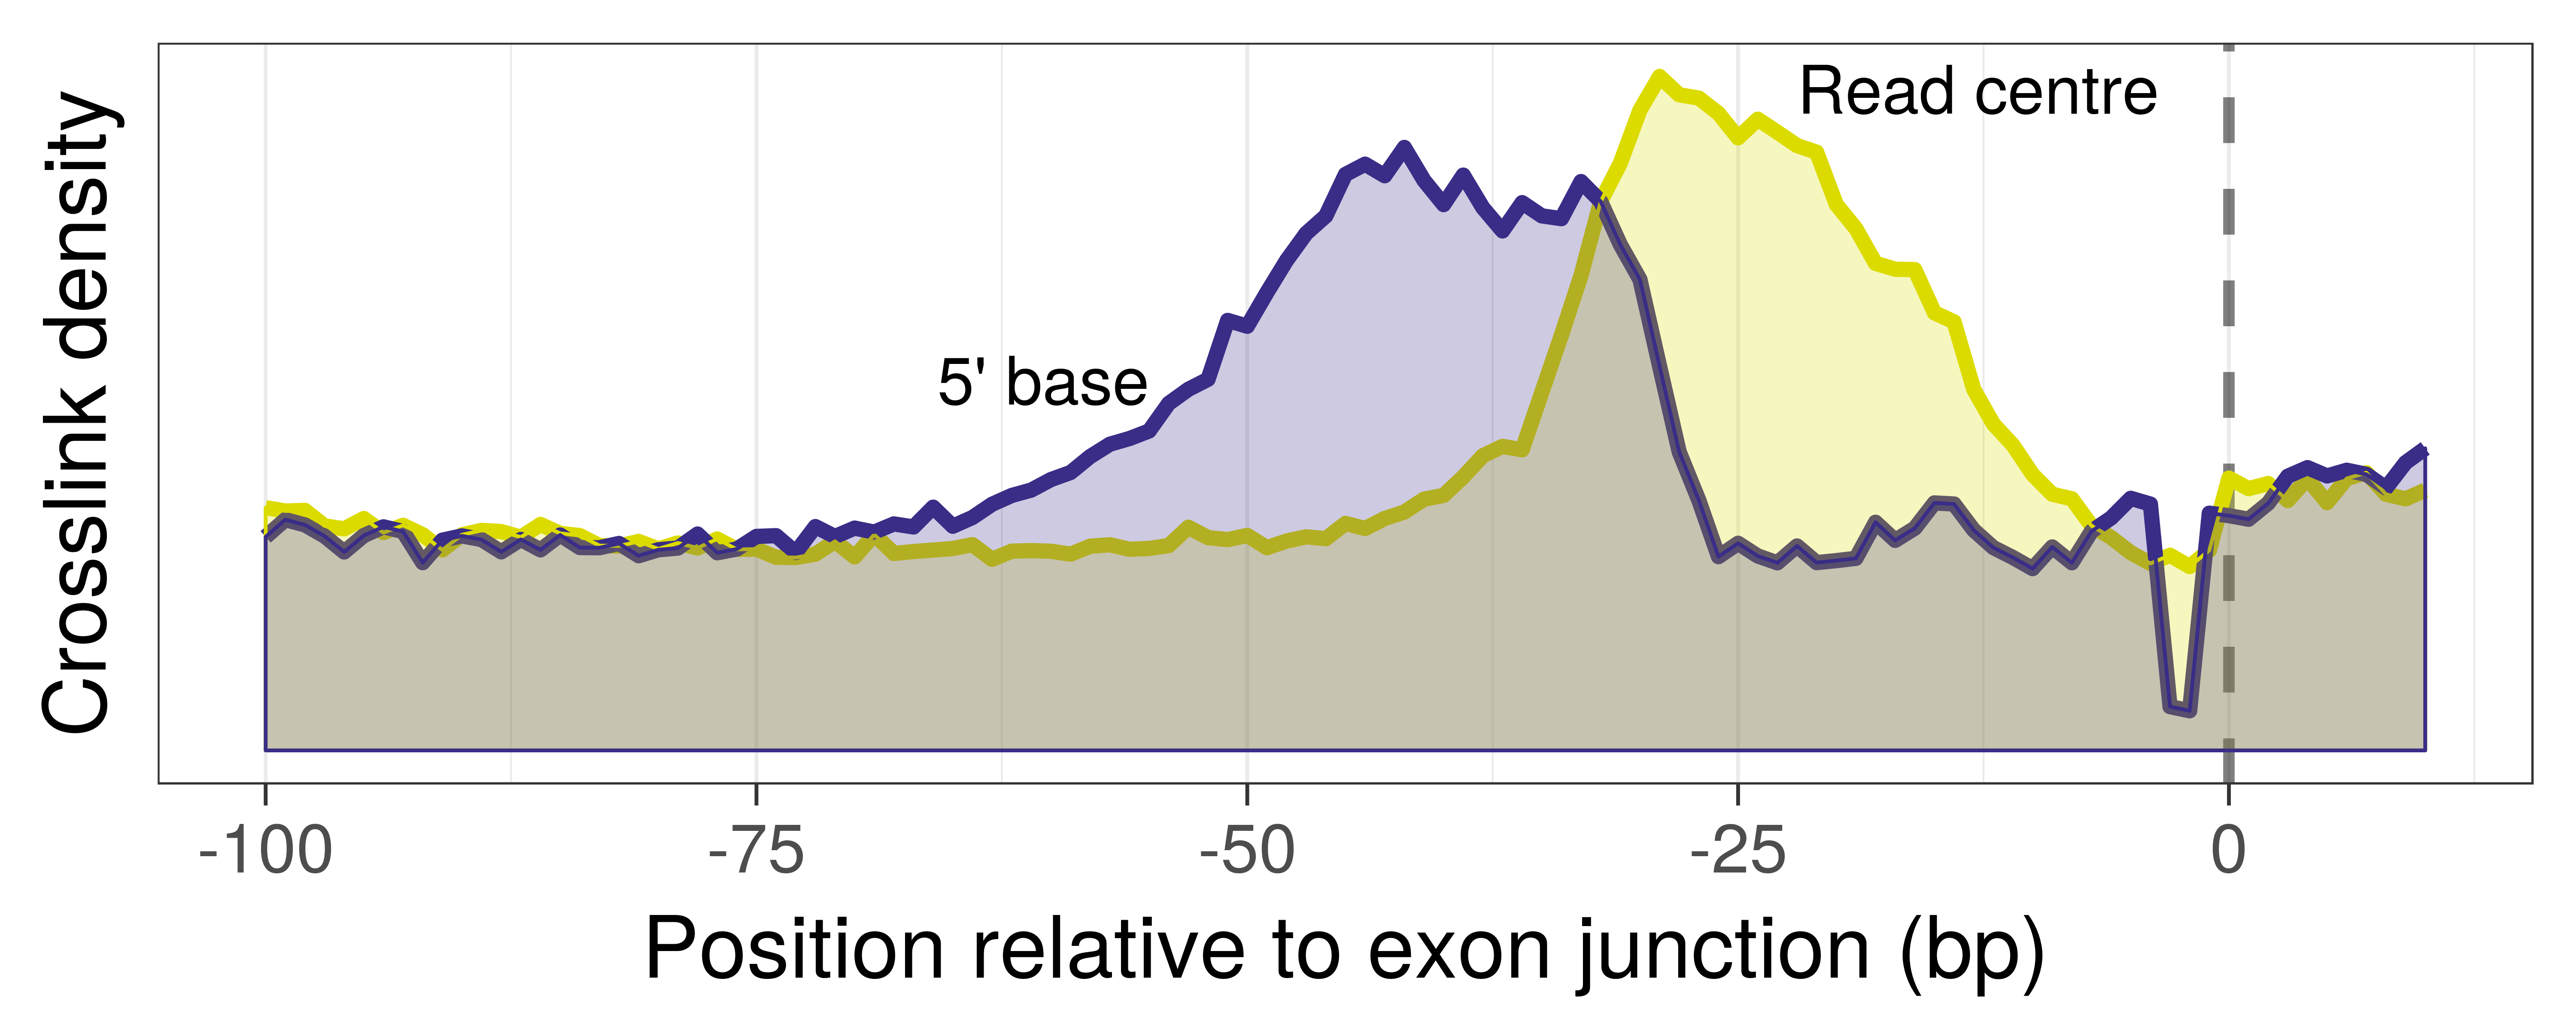

In [56]:
%%R -i results -w 10 -h 4 -u in -r 600
library(ggplot2)
library(tidyr)
pal = c("X5..base"=rgb(57,45,135, maxColorValue=255), 
        "Centre"=rgb(220,219,0, maxColorValue=255))
gather(results, "Base", "density", -index) %>%
    ggplot() + aes(index, density, col=Base, fill=Base) +
    geom_vline(xintercept=0, lty=2, lwd=1.5,  alpha=0.5) +
    geom_line(lwd=2) +
    geom_area(position="identity", alpha=0.25) + 
    xlim(c(-100,10)) +
    scale_fill_manual(values=pal) +
    scale_color_manual(values=pal) +
    scale_y_continuous(breaks=NULL, name="Crosslink density") +
    xlab("Position relative to exon junction (bp)") +
    guides(fill=FALSE, col=FALSE) +
    annotate(geom="text", label = c("5' base", "Read centre"), x=c(-55,-22), y=c(700,1250),
            hjust=c(1,0), size=6.53) +
    theme_bw(base_size=24)

In [183]:
iclip_data = make_getter(plus_wig="eIF4A3-GFP.clusters.bw")
gtffile = GTF.iterator(IOTools.openFile("ensembl75.gtf.gz"))
cluster_binding_matrix = get_junction_profiles(iclip_data, gtffile)

In [192]:
norm_cluster_matrix = cluster_binding_matrix.apply(lambda x: x/x.sum(), axis=1)
cluster_profile = norm_cluster_matrix.sum()
cluster_profile = (cluster_profile/cluster_profile.sum()).reset_index()
cluster_profile.columns = ["base", "density"]

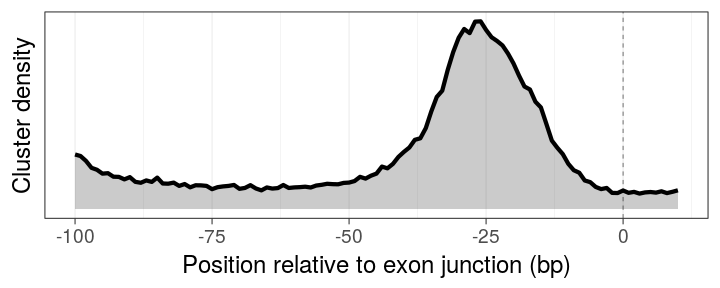

In [201]:
%%R -i cluster_profile -w 10 -h 4 -u in -r 300

ggplot(cluster_profile) + aes(base, density) +
    geom_vline(xintercept=0, lty=2, alpha=0.5, col=pal[1]) +
    geom_area( alpha=0.25, fill=pal[1]) +
    geom_line( lwd=2) +
    xlim(c(-100,10)) +
    scale_y_continuous(breaks=NULL, name = "Cluster density") +
    xlab("Position relative to exon junction (bp)") +
    theme_bw(base_size=24)